In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd

# Load dataset
file_path = "output2.xlsx"
df = pd.read_excel(file_path)

# Extract numeric year columns
year_columns = [col for col in df.columns if isinstance(col, int)]
feature_years = [col for col in year_columns if col <= 2022]
df_features = df[feature_years].copy()

# Save identifiers
countries = df['Country']
sectors = df['Sector']

# Scale input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

# Format for LSTM
X_lstm = np.expand_dims(X_scaled, axis=1)

# Target for 2023
y_2023 = df[2023]

# ----- Train base models on 1970–2022 to predict 2023 -----
# Linear Regression
lr_model = LinearRegression().fit(df_features, y_2023)
lr_2023 = lr_model.predict(df_features)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42).fit(df_features, y_2023)
rf_2023 = rf_model.predict(df_features)

# ANN
def build_ann_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

ann_model = build_ann_model((X_scaled.shape[1],))
ann_model.fit(X_scaled, y_2023, epochs=50, batch_size=16, validation_split=0.2, verbose=0,
              callbacks=[EarlyStopping(monitor='val_loss', patience=5)])
ann_2023 = ann_model.predict(X_scaled).flatten()

# LSTM
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, activation='relu', return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model

lstm_model = build_lstm_model((1, X_scaled.shape[1]))
lstm_model.fit(X_lstm, y_2023, epochs=50, batch_size=16, validation_split=0.2, verbose=0,
               callbacks=[EarlyStopping(monitor='val_loss', patience=5)])
lstm_2023 = lstm_model.predict(X_lstm).flatten()

# Ensemble 2023 prediction
ensemble_2023 = (0.2 * lr_2023 + 0.3 * rf_2023 + 0.25 * ann_2023 + 0.25 * lstm_2023)

# ----- Predict 2024 -----
X_2024 = np.column_stack([df_features.values, ensemble_2023])
scaler_2024 = StandardScaler()
X_2024_scaled = scaler_2024.fit_transform(X_2024)
X_2024_lstm = np.expand_dims(X_2024_scaled, axis=1)

# Retrain all models on new input
lr_2024_model = LinearRegression().fit(X_2024, ensemble_2023)
rf_2024_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42).fit(X_2024, ensemble_2023)
ann_2024_model = build_ann_model((X_2024_scaled.shape[1],))
ann_2024_model.fit(X_2024_scaled, ensemble_2023, epochs=50, batch_size=16, validation_split=0.2, verbose=0,
                   callbacks=[EarlyStopping(monitor='val_loss', patience=5)])
lstm_2024_model = build_lstm_model((1, X_2024_scaled.shape[1]))
lstm_2024_model.fit(X_2024_lstm, ensemble_2023, epochs=50, batch_size=16, validation_split=0.2, verbose=0,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# Predict 2024
lr_2024 = lr_2024_model.predict(X_2024)
rf_2024 = rf_2024_model.predict(X_2024)
ann_2024 = ann_2024_model.predict(X_2024_scaled).flatten()
lstm_2024 = lstm_2024_model.predict(X_2024_lstm).flatten()
ensemble_2024 = (0.2 * lr_2024 + 0.3 * rf_2024 + 0.25 * ann_2024 + 0.25 * lstm_2024)

# ----- Predict 2025 -----
X_2025 = np.column_stack([X_2024, ensemble_2024])
scaler_2025 = StandardScaler()
X_2025_scaled = scaler_2025.fit_transform(X_2025)
X_2025_lstm = np.expand_dims(X_2025_scaled, axis=1)

lr_2025_model = LinearRegression().fit(X_2025, ensemble_2024)
rf_2025_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42).fit(X_2025, ensemble_2024)
ann_2025_model = build_ann_model((X_2025_scaled.shape[1],))
ann_2025_model.fit(X_2025_scaled, ensemble_2024, epochs=50, batch_size=16, validation_split=0.2, verbose=0,
                   callbacks=[EarlyStopping(monitor='val_loss', patience=5)])
lstm_2025_model = build_lstm_model((1, X_2025_scaled.shape[1]))
lstm_2025_model.fit(X_2025_lstm, ensemble_2024, epochs=50, batch_size=16, validation_split=0.2, verbose=0,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# Predict 2025
lr_2025 = lr_2025_model.predict(X_2025)
rf_2025 = rf_2025_model.predict(X_2025)
ann_2025 = ann_2025_model.predict(X_2025_scaled).flatten()
lstm_2025 = lstm_2025_model.predict(X_2025_lstm).flatten()
ensemble_2025 = (0.2 * lr_2025 + 0.3 * rf_2025 + 0.25 * ann_2025 + 0.25 * lstm_2025)

# ----- Final Result -----
df_result = pd.DataFrame({
    'Country': countries,
    'Sector': sectors,
    'Predicted_2024': ensemble_2024,
    'Predicted_2025': ensemble_2025
})

df_result.head()


C:\Users\LENOVO\OneDrive\Desktop\Tensorflow\tfenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


C:\Users\LENOVO\OneDrive\Desktop\Tensorflow\tfenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


C:\Users\LENOVO\OneDrive\Desktop\Tensorflow\tfenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\LENOVO\OneDrive\Desktop\Tensorflow\tfenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


C:\Users\LENOVO\OneDrive\Desktop\Tensorflow\tfenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\LENOVO\OneDrive\Desktop\Tensorflow\tfenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


,Country,Sector,Predicted_2024,Predicted_2025
0,Albania,Agriculture,0.164638,0.304100
1,Argentina,Agriculture,1.162686,0.976397
2,Australia,Agriculture,1.937806,1.611592
3,Austria,Agriculture,0.172215,0.312794
4,Azerbaijan,Agriculture,0.204016,0.332345


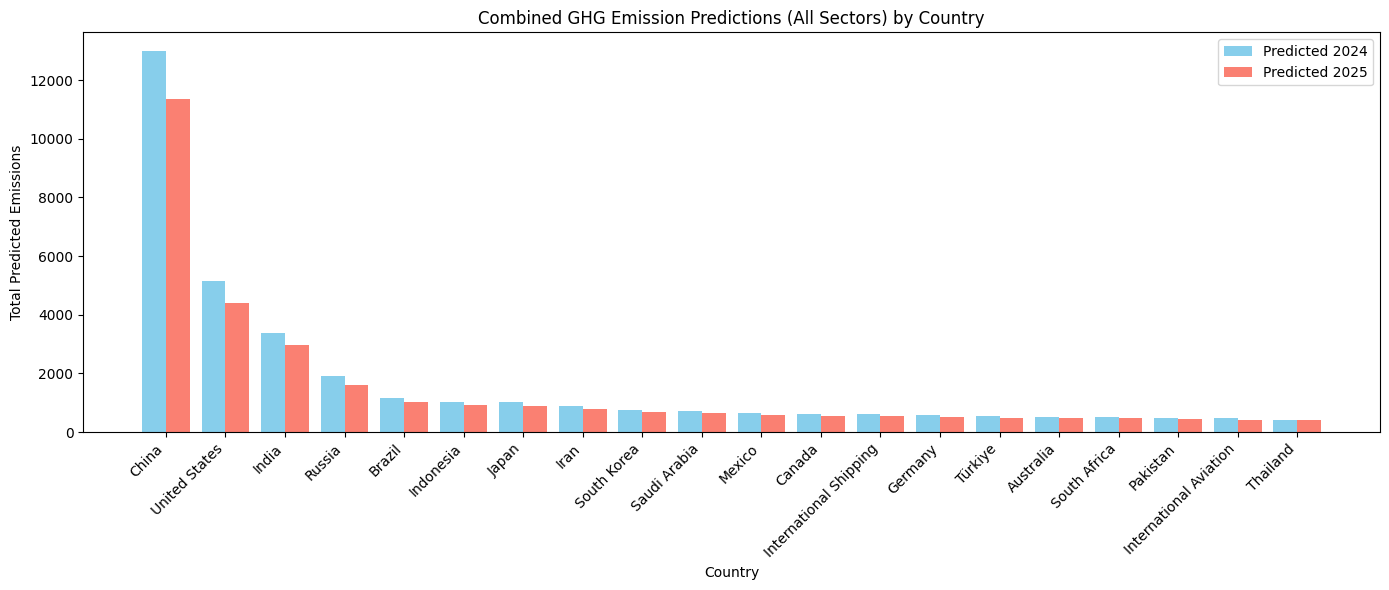

In [4]:
import matplotlib.pyplot as plt

# Group by Country and sum the predicted emissions
df_country_sum = df_result.groupby('Country')[['Predicted_2024', 'Predicted_2025']].sum().reset_index()

# Sort by Predicted_2025 (optional)
df_country_sum = df_country_sum.sort_values(by='Predicted_2025', ascending=False).head(20)

# Plot
plt.figure(figsize=(14, 6))
bar_width = 0.4
index = range(len(df_country_sum))

# Bar plots
plt.bar(index, df_country_sum['Predicted_2024'], bar_width, label='Predicted 2024', color='skyblue')
plt.bar([i + bar_width for i in index], df_country_sum['Predicted_2025'], bar_width, label='Predicted 2025', color='salmon')

# Country labels
plt.xticks([i + bar_width/2 for i in index], df_country_sum['Country'], rotation=45, ha='right')

plt.xlabel('Country')
plt.ylabel('Total Predicted Emissions')
plt.title('Combined GHG Emission Predictions (All Sectors) by Country')
plt.legend()
plt.tight_layout()
plt.show()
